In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
tf  = 30
dt  = 0.001
t = np.arange(dt, tf + dt, dt)

In [40]:
n = 3
r = 16

In [41]:
# True parameters
m    = 23.8
Iz   = 1.76
xg   = 0.046

Xud  = -2
Yvd  = -10
Yrd  = 0
Nvd  = 0
Nrd  = -1

Xu   = -0.7225
Xuu  = -1.3274
Yv   = -0.8612
Yvv  = -36.2823
Yr   = 0.1079
Nv   = 0.1052
Nr  = -0.5
Nrr = -1

In [42]:
# Mass elements
m11 = m - Xud
m22 = m - Yvd
m23 = m * xg - Yrd
m32 = m * xg - Nvd
m33 = Iz - Nrd

In [43]:
# System Description
M = np.array([[m11, 0, 0], [0, m22, m23], [0, m32, m33 ]])
B = dt * np.vstack([np.zeros((3, M.shape[1])), np.linalg.inv(M)])
C = np.array([[0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

In [44]:
# State initialization
x = np.array([3, 3, 0, 0, 0, 0]).reshape(-1, 1)
y = np.array([0, 0, 0]).reshape(-1, 1)
vhat = np.array([0, 0, 0]).reshape(-1, 1)
thetahat = np.zeros((r,1))

In [45]:
mt = m22*m33-m23*m32

In [46]:
alpha1 = dt * (m - Yvd) / (m - Xud)
alpha2 = dt * (m * xg - Yrd) / (m - Xud)
alpha3 = (-dt * (Iz - Nrd) * (m - Xud) / mt) + (dt * (m * xg - Yrd) * (m * xg - Yrd) / mt)
alpha4 = dt * (m * xg - Yrd) * (Xud - Yvd) / mt
alpha5 = (dt * (m * xg - Nvd) * (m - Xud) / mt) - (dt * (m - Yvd) * (m * xg - Yrd) / mt)
alpha6 = -dt * (m - Yvd) * (Xud - Yvd) / mt

beta1  = dt * Xu / (m - Xud)
beta2  = dt * Xuu / (m - Xud)
beta3  = (dt * (Iz - Nrd) * Yv / mt) - (dt * (m * xg - Yrd) * Nv / mt)
beta4  = (dt * (Iz - Nrd) * Yr / mt) - (dt * (m * xg - Yrd) * Nr / mt)
beta5  = dt * (Iz - Nrd) * Yvv / mt
beta6  = -dt * (m * xg - Yrd) * Nrr / mt
beta7  = (dt * (m - Yvd) * Nv / mt) - (dt * (m * xg - Nvd) * Yv / mt)
beta8  = (dt * (m - Yvd) * Nr / mt) - (dt * (m * xg - Nvd) * Yr / mt)
beta9  = -dt * (m * xg - Nvd) * Yvv / mt
beta10 = dt * (m - Yvd) * Nrr / mt

In [47]:
# Initial control inputs
u = np.array([5, 10, 0]).reshape(3,1)

In [48]:
# Plotting
uArray          = []
xArray          = []
yArray          = []
vhatArray       = []
thetahatArray   = []

In [49]:
# Initialization for estimator
Pplus       = 10000000000 * np.eye(n)
QF          = 0.0001 * np.eye(n)
RF          = 0.0001 * np.eye(n)
a           = 0.999
UpsilonPlus = np.zeros((n, r))
S           = 10000000000 * np.eye(r)
lambda_     = 0.999  # 'lambda' is a reserved keyword in Python, so we rename it to 'lambda_'

In [50]:
# Simulation loop
for i in range(int(tf/dt)):
    
    # u = np.array([40*np.sin(i*dt), 10*np.cos(i*dt), np.cos(i*dt)])  # Uncomment for dynamic control inputs
    
    uArray.append(u)
    xArray.append(x)
    yArray.append(y)
    vhatArray.append(vhat)
    thetahatArray.append(thetahat)
    
    Cvv = np.array([alpha1*x[4]*x[5] + alpha2*x[5]**2,
                    alpha3*x[3]*x[5] + alpha4*x[3]*x[4],
                    alpha5*x[3]*x[5] + alpha6*x[3]*x[4]])

    Dvv = np.array([beta1*x[3] + beta2*abs(x[3])*x[3],
                    beta3*x[4] + beta4*x[5] + beta5*abs(x[4])*x[4] + beta6*abs(x[5])*x[5],
                    beta7*x[4] + beta8*x[5] + beta9*abs(x[4])*x[4] + beta10*abs(x[5])*x[5]])

    # Equation 30 - working
    x = x + np.concatenate(
        [np.array([
            dt*(np.cos(x[2])*x[3] - np.sin(x[2])*x[4]),
            dt*(np.sin(x[2])*x[3] + np.cos(x[2])*x[4]),
            dt*x[5]
        ]), 
         Cvv + Dvv]) + B @ u

    y = C @ x

    Phi = np.array([[vhat[1].item() * vhat[2].item(), vhat[2].item()**2, vhat[0].item(), abs(vhat[0].item()) * vhat[0].item(), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, vhat[0].item() * vhat[2].item(), vhat[0].item() * vhat[1].item(), vhat[1].item(), vhat[2].item(), abs(vhat[1].item()) * vhat[1].item(), abs(vhat[2].item()) * vhat[2].item(), 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, vhat[0].item() * vhat[2].item(), vhat[0].item() * vhat[1].item(), vhat[1].item(), vhat[2].item(), abs(vhat[1].item()) * vhat[1].item(), abs(vhat[2].item()) * vhat[2].item()]])
    

    # Estimation using adaptive KF
    Pmin  = Pplus + QF
    Sigma = Pmin + RF
    KF    = Pmin @ np.linalg.inv(Sigma)
    Pplus = (np.eye(n) - KF) @ Pmin

    ytilde = y - (vhat + dt * np.linalg.inv(M) @ u + Phi @ thetahat)

    QF     = a * QF + (1 - a) * (KF @ (ytilde @ ytilde.T) @ KF.T)
    RF     = a * RF + (1 - a) * (ytilde @ ytilde.T + Pmin)
 
    Upsilon = (np.eye(n) - KF) @ np.eye(n) @ UpsilonPlus + (np.eye(n) - KF) @ Phi
    Omega   = np.eye(n) @ UpsilonPlus + Phi
    Lambda  = np.linalg.inv(lambda_ * Sigma + Omega @ S @ Omega.T)
    Gamma1  = S @ Omega.T @ Lambda
    S       = (1 / lambda_) * S - (1 / lambda_) * S @ Omega.T @ Lambda @ Omega @ S
    UpsilonPlus = Upsilon

    thetahat  = thetahat + Gamma1 @ ytilde;

    vhat      = vhat + dt * np.linalg.inv(M) @ u + Phi @ thetahat + KF @ ytilde + Upsilon @ Gamma1 @ ytilde

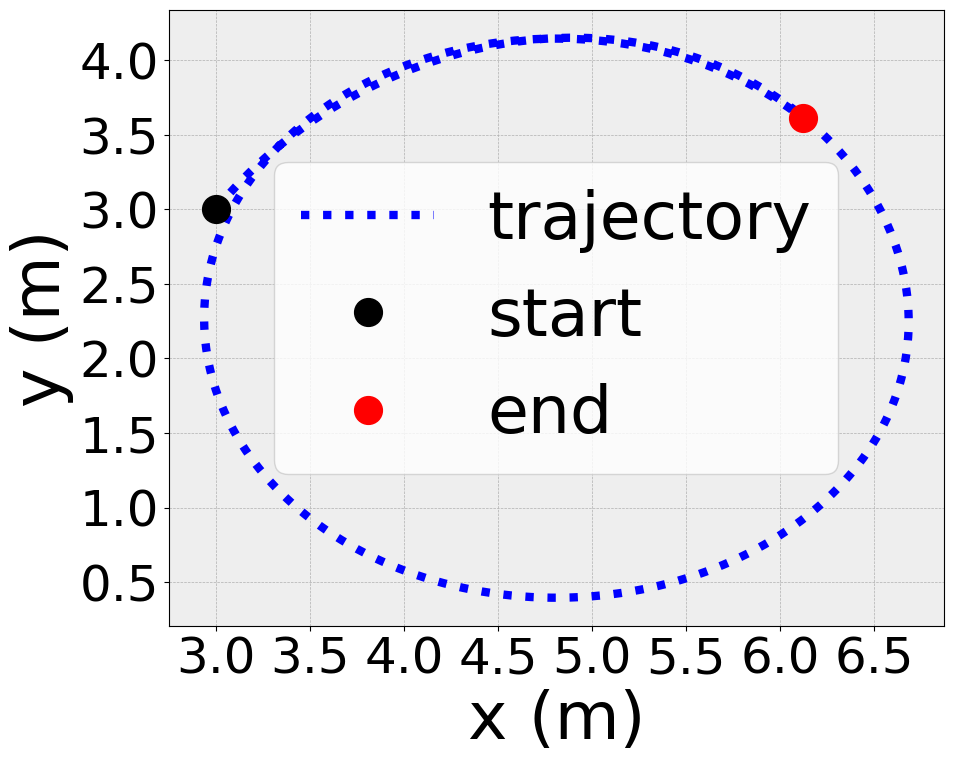

In [51]:
xArray_matrix = np.hstack(xArray)  # Shape becomes (6, N)

# Extract x and y coordinates (first two rows)
x_values = xArray_matrix[0, :]
y_values = xArray_matrix[1, :]

plt.figure(figsize=(10, 8))

# Plot trajectory
plt.plot(x_values, y_values, ':b', linewidth=6, label='trajectory')

# Plot start point
plt.plot(x_values[0], y_values[0], 'ok', markersize=20, label='start')

# Plot end point
plt.plot(x_values[-1], y_values[-1], 'or', markersize=20, label='end')

# Customize grid and labels
plt.gca().set_facecolor('#EEEEEE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.xlabel('x (m)', fontsize=48)
plt.ylabel('y (m)', fontsize=48)
plt.legend(fontsize=48)
plt.show()


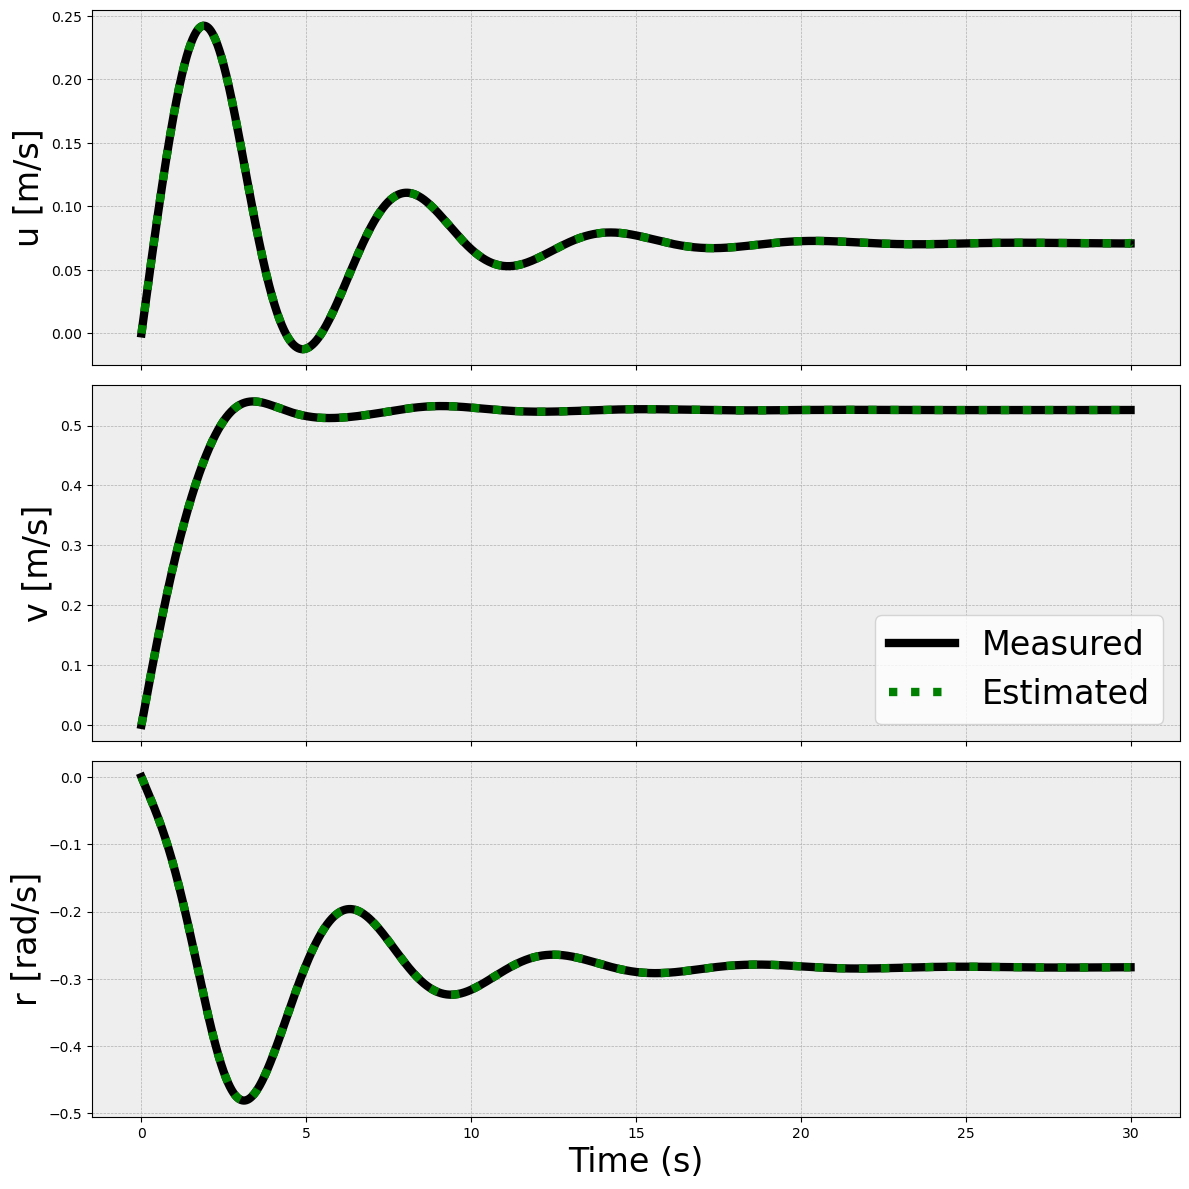

In [52]:
yArray = np.hstack(yArray)  # Convert list of (3,1) arrays into a (3, N) matrix
vhatArray = np.hstack(vhatArray)  # Do the same for vhatArray

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors
bg_color = '#EEEEEE'
line_width = 6
font_size = 24

# Subplot 1: u [m/s]
axes[0].plot(t, yArray[0, :], '-k', linewidth=line_width, label='Measured')
axes[0].plot(t, vhatArray[0, :], ':g', linewidth=line_width, label='Estimated')
axes[0].set_ylabel('u [m/s]', fontsize=font_size)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor(bg_color)

# Subplot 2: v [m/s]
axes[1].plot(t, yArray[1, :], '-k', linewidth=line_width, label='Measured')
axes[1].plot(t, vhatArray[1, :], ':g', linewidth=line_width, label='Estimated')
axes[1].set_ylabel('v [m/s]', fontsize=font_size)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor(bg_color)
axes[1].legend(fontsize=font_size)

# Subplot 3: r [rad/s]
axes[2].plot(t, yArray[2, :], '-k', linewidth=line_width, label='Measured')
axes[2].plot(t, vhatArray[2, :], ':g', linewidth=line_width, label='Estimated')
axes[2].set_ylabel('r [rad/s]', fontsize=font_size)
axes[2].set_xlabel('Time (s)', fontsize=font_size)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_facecolor(bg_color)

# Apply general figure settings
plt.tight_layout()
plt.show()

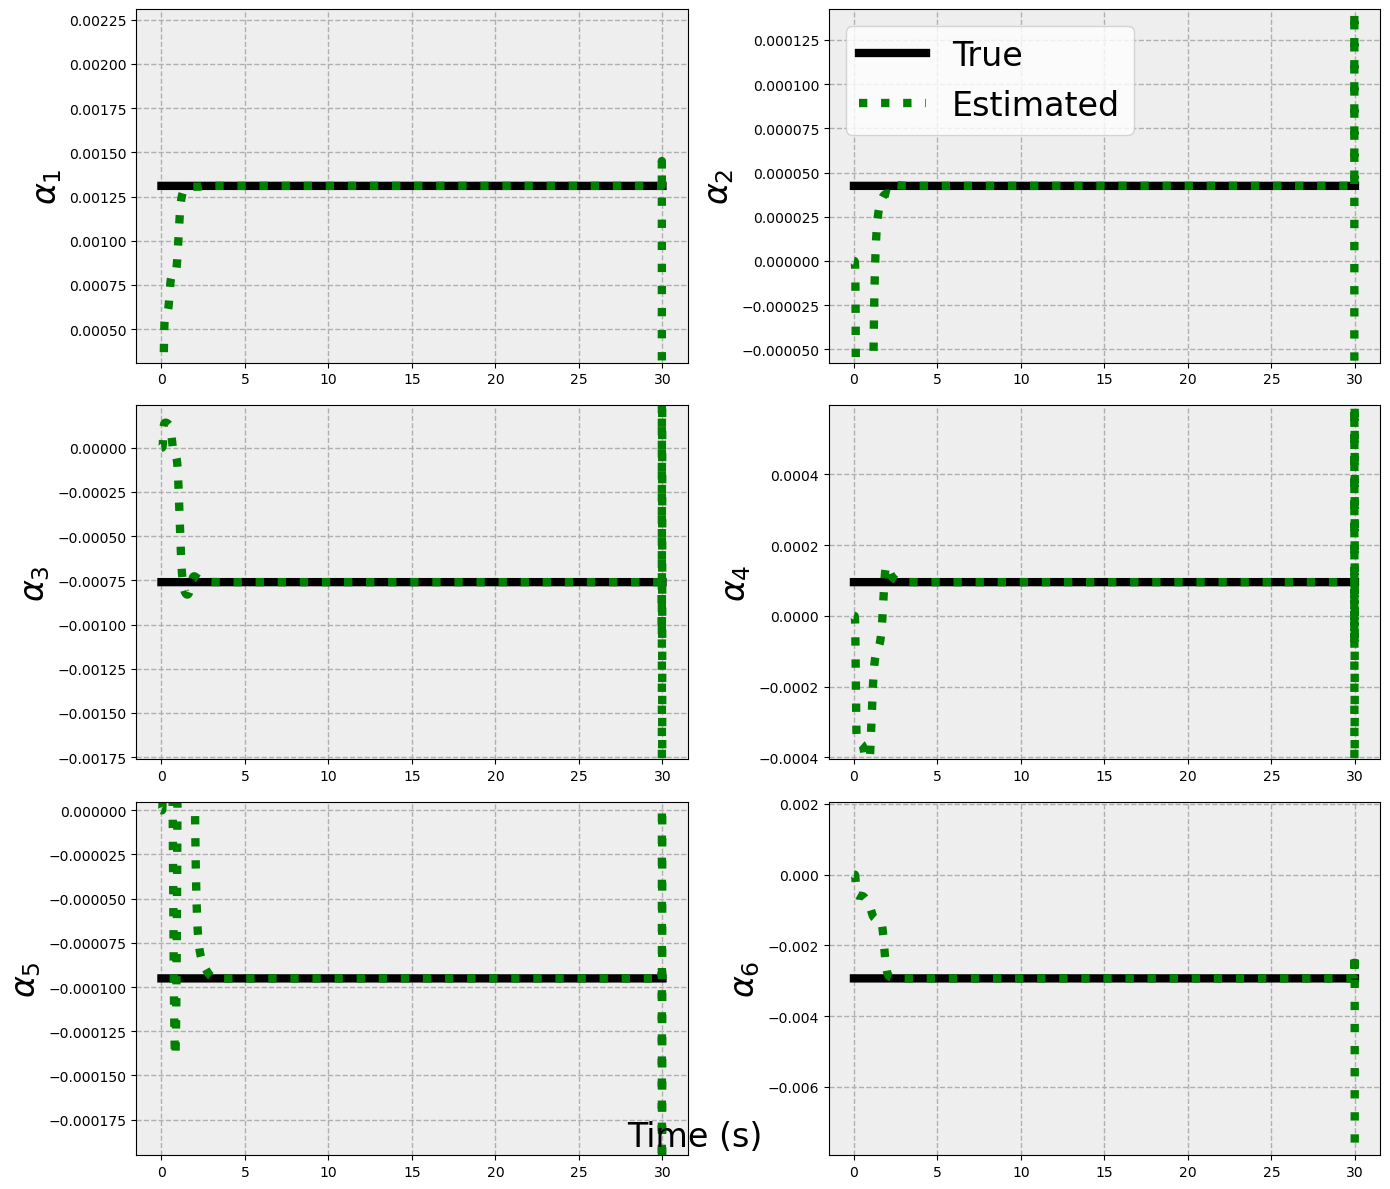

In [55]:
thetahatArray = np.array(thetahatArray)  # Convert to NumPy array
thetahatArray = np.squeeze(thetahatArray)  # Remove extra dimensions if needed
thetahatArray = thetahatArray.T  # Ensure correct shape (parameters, time steps)

# Set up subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
line_width = 6
font_size = 24

# Subplot 1: α1
axes[0, 0].plot(t, np.full(len(t), alpha1), '-k', linewidth=line_width, label='True')
axes[0, 0].plot(t, thetahatArray[0, :], ':g', linewidth=line_width, label='Estimated')
axes[0, 0].set_ylabel(r'$\alpha_1$', fontsize=font_size)
axes[0, 0].set_ylim([alpha1 - 0.001, alpha1 + 0.001])

# Subplot 2: α2
axes[0, 1].plot(t, np.full(len(t), alpha2), '-k', linewidth=line_width, label='True')
axes[0, 1].plot(t, thetahatArray[1, :], ':g', linewidth=line_width, label='Estimated')
axes[0, 1].set_ylabel(r'$\alpha_2$', fontsize=font_size)
axes[0, 1].set_ylim([alpha2 - 0.0001, alpha2 + 0.0001])
axes[0, 1].legend(fontsize=font_size)

# Subplot 3: α3
axes[1, 0].plot(t, np.full(len(t), alpha3), '-k', linewidth=line_width)
axes[1, 0].plot(t, thetahatArray[4, :], ':g', linewidth=line_width)
axes[1, 0].set_ylabel(r'$\alpha_3$', fontsize=font_size)
axes[1, 0].set_ylim([alpha3 - 0.001, alpha3 + 0.001])

# Subplot 4: α4
axes[1, 1].plot(t, np.full(len(t), alpha4), '-k', linewidth=line_width)
axes[1, 1].plot(t, thetahatArray[5, :], ':g', linewidth=line_width)
axes[1, 1].set_ylabel(r'$\alpha_4$', fontsize=font_size)
axes[1, 1].set_ylim([alpha4 - 0.0005, alpha4 + 0.0005])

# Subplot 5: α5
axes[2, 0].plot(t, np.full(len(t), alpha5), '-k', linewidth=line_width)
axes[2, 0].plot(t, thetahatArray[10, :], ':g', linewidth=line_width)
axes[2, 0].set_ylabel(r'$\alpha_5$', fontsize=font_size)
axes[2, 0].set_ylim([alpha5 - 0.0001, alpha5 + 0.0001])

# Subplot 6: α6
axes[2, 1].plot(t, np.full(len(t), alpha6), '-k', linewidth=line_width)
axes[2, 1].plot(t, thetahatArray[11, :], ':g', linewidth=line_width)
axes[2, 1].set_ylabel(r'$\alpha_6$', fontsize=font_size)
axes[2, 1].set_ylim([alpha6 - 0.005, alpha6 + 0.005])

# Formatting
for ax in axes.flat:
    ax.grid(True, which='both', linestyle='--', linewidth=1)
    ax.set_facecolor('#EEEEEE')

# Labels
fig.text(0.5, 0.04, 'Time (s)', ha='center', fontsize=font_size)
plt.tight_layout()
plt.show()

In [37]:
thetahatArray

array([ 0.00000000e+00,  1.93798450e-04,  3.87596899e-04, ...,
       -2.82888982e-01, -2.82888750e-01, -2.82888518e-01], shape=(90000,))